In [2]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from MEM_class import MEM

from synthData_Gen import SyntheticData_Gen

Generate a time series of synthetic data through an AR1 process:

In [3]:
s1_instance = SyntheticData_Gen(AR1_coef = 0.3, AR1_var = 120, AR1_dt = 0.001, AR1_N = 20000, diff_len=0.08, dt_sample = 0.025, meas_noise = 0.07)
s1 = s1_instance()

Plot said time series, both raw AR1 process and sampled/diffused series.

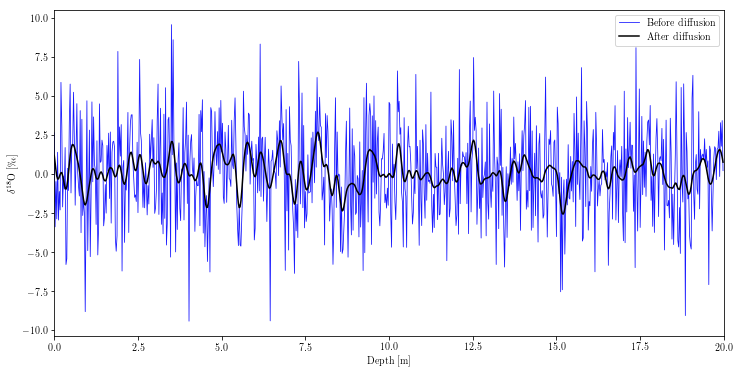

In [4]:
plotFig = True
if plotFig:
    figSynth, axSynth = plt.subplots(figsize=(12,6))
    axSynth.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
    axSynth.plot(s1[2],s1[3],linewidth=0.8, color='blue', alpha=0.9,label='Before diffusion')
    axSynth.plot(s1[4],s1[5], color='black', label='After diffusion')
    axSynth.legend()
    figSynth.savefig('SynthData.png')

Plot only the sampled/diffused data.

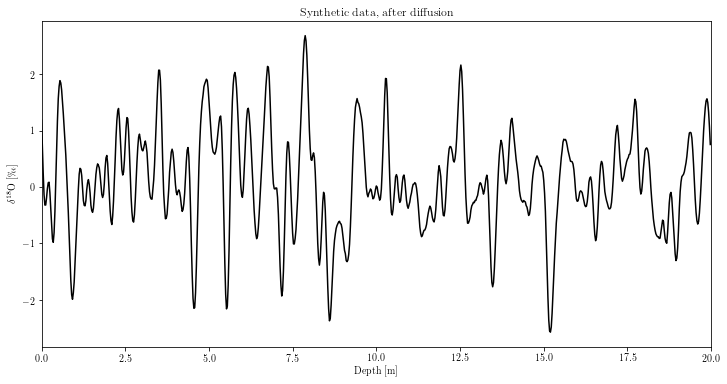

In [5]:
if plotFig:
    figSynthDiff, axSynthDiff = plt.subplots(figsize=(12,6))
    axSynthDiff.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]', title='Synthetic data, after diffusion')
    axSynthDiff.plot(s1[4],s1[5], color='black')


Define depth and signal data from synthetic data. Create an instance of a signal to use for spectral analysis.

In [5]:
depth = s1[4]
data = s1[5]
dt = depth[1] - depth[0]

from SpectralAnalysis import SignalToF

psdType_in = 'FFT'
s_inst = SignalToF(t = depth, y = data, psdType = psdType_in)

Generate a PSD for the signal (given the PSD type wanted {'FFT', 'MEM'}).

Compute the optimal filter through a fit to the PSD data. 

Use fit params to create signal and noise data.

Plot PSD data, fit, signal and noise.

Print out estimate of diffusion length.

Using default boundaries for variance and a1
Diff. len., fit [cm]: 7.012


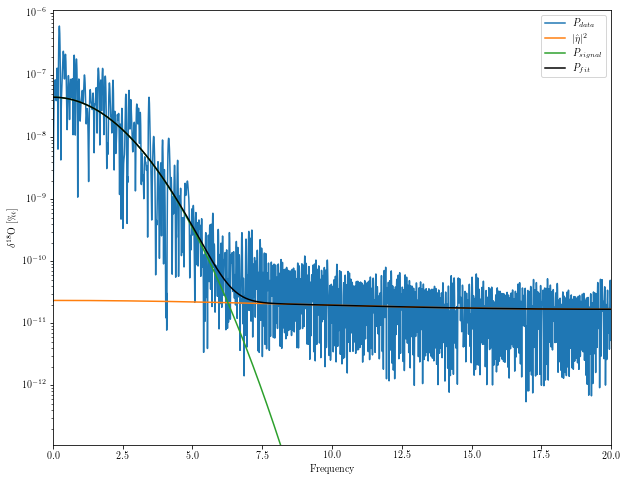

In [6]:
def func_Noise(w, s_eta2, a1, dz):
    return (s_eta2**2 * dz) / (np.abs(1 - a1 * np.exp(- 2 * np.pi * 1j * w * dz))**2)

def func_Signal(w, p0, s_tot2):
    return p0 * np.exp(- (2 * np.pi * w * s_tot2)**2)

if psdType_in == 'FFT':
    PSD = s_inst.fft_psd(N=8192)
elif psdType_in == 'MEM':
    PSD = s_inst.mem(M=40,N=8192)
w_PSD = PSD[0]
P_PSD = PSD[1]


optFit = s_inst.OptFilterFit()
P_Fit = optFit[1]

Pnoise = func_Noise(w_PSD, optFit[0]['s_eta2_fit'],optFit[0]['a1_fit'], dt)
Psignal = func_Signal(w_PSD, optFit[0]['P0_fit'], optFit[0]['s_tot2_fit'])

plotFig = True
if plotFig == True:
    figPSDfit, axPSDfit = plt.subplots(figsize=(10,8))
    axPSDfit.set(ylim=(min(P_PSD)-min(P_PSD)*0.8, max(P_PSD)+max(P_PSD)*0.8), xlim=(min(w_PSD), max(w_PSD)),\
                ylabel='$\delta^{18}$O [\permil]', xlabel='Frequency')
    axPSDfit.semilogy(w_PSD, P_PSD, label='$P_{data}$')
    axPSDfit.semilogy(w_PSD, Pnoise, label='$|\hat{\eta}|^2$')
    axPSDfit.semilogy(w_PSD, Psignal, label='$P_{signal}$')
    axPSDfit.semilogy(w_PSD, P_Fit, color='k', label='$P_{fit}$')
   # if psdType_in == 'FFT':
   #     axMEMfit.semilogy(w_PSD, P_Fit, color='k', label='$P_{fit}$')
   # elif psdType_in == 'MEM': 
   #     axMEMfit.semilogy(w_PSD, P_Fit[:-1], color='k', label='$P_{fit}$')
    axPSDfit.legend()
    #figPSDfit.savefig('FFT_PSD_fit.png')
s_eta2_fit = optFit[0]['s_eta2_fit']
s_tot2_fit = optFit[0]['s_tot2_fit']
#print(f'\nVariance, fit: {s_eta2_fit:.3f}')
print(f'Diff. len., fit [cm]: {s_tot2_fit*100:.3f}')

Deconvolve the signal

In [7]:
w, F, T, R, Fsig, Fnoi, dEst = s_inst.convolve()

Using default boundaries for variance and a1


/home/thea/Documents/KUFysik/MesterTesen/Analysis/SpectralAnalysis.py:325: RuntimeWarning: invalid value encountered in true_divide
  T = ((np.sin(np.pi * wConv * dt)) / (np.pi * wConv * dt)) * T


Plot the estimate of the optimal filter, transfer fct., inverse of transfer fct. and restoration filter in a loglog plot.

/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000
/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


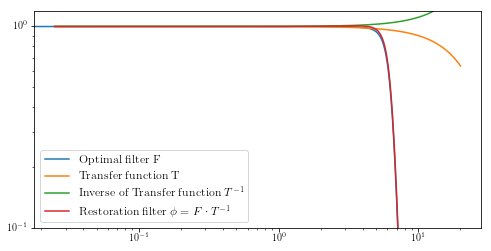

In [8]:
figFilt, axFilt = plt.subplots(figsize=(8,4))
axFilt.loglog(w,F, label='Optimal filter F')
axFilt.loglog(w,T, label='Transfer function T')
axFilt.loglog(w,T**(-1), label = 'Inverse of Transfer function $T^{-1}$')
axFilt.loglog(w,R, label='Restoration filter $\phi = F \cdot T^{-1}$')
axFilt.set(ylim=(0.1,1.2))#, xlim=(0.01, 7.5))
axFilt.legend(fontsize=12)

Plot the estimate of the optimal filter, transfer fct., inverse of transfer fct. and restoration filter.

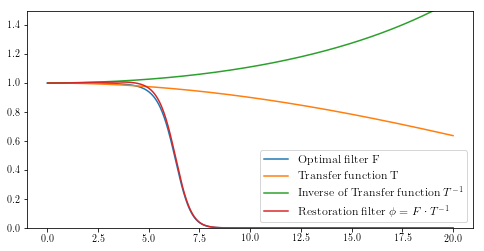

In [9]:
figFilt, axFilt = plt.subplots(figsize=(8,4))
axFilt.plot(w,F, label='Optimal filter F')
axFilt.plot(w,T, label='Transfer function T')
axFilt.plot(w,T**(-1), label = 'Inverse of Transfer function $T^{-1}$')
axFilt.plot(w,R, label='Restoration filter $\phi = F \cdot T^{-1}$')

axFilt.set(ylim=(0,1.5))#, xlim=(0.01, 7.5))
axFilt.legend(fontsize=12)

Plot the diffused and estimated deconvolved data together.

/home/thea/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


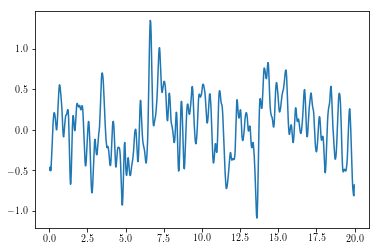

In [10]:
plt.plot(depth[2:],np.fft.ifft(np.fft.fft(data)[2:]*R[2:]))

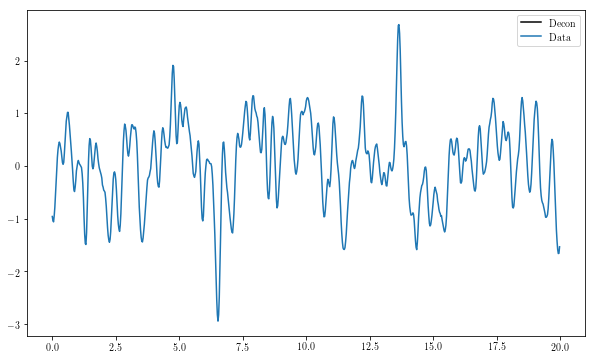

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(depth,dEst,'k', label='Decon')
ax.plot(depth,data, label='Data')
ax.legend()

In [1]:
import scipy.fft